# Отток клиентов. Описание проекта

*Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.*

**Признаки**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата
**Целевой признак**
- `Exited` — факт ухода клиента

In [50]:
# Импорт стандартной библиотеки
import pandas as pd
import numpy as np
import xgboost as xgb
import imblearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Сторонний импорт
from collections import Counter
from fast_ml.model_development import train_valid_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, mean_absolute_error, f1_score, roc_curve, roc_auc_score
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.mode.chained_assignment = None


In [51]:
display(df)
print(df.info())
display(df.describe())
print()
print('Количество дубликатов:', df.duplicated().sum())


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



Количество дубликатов: 0


### Анализ данных
- в таблице нет дубликатов.
- пропуски Tenure. Не у всех указано "сколько лет является клиентом банка".
- столбцы 'RowNumber','CustomerId','Surname' содержат слишком индивидуальную информацию - индекс строки, id, фамилию. Эти данные могут сбить качество обучения  модели. Кроме того, по ним нельзя сказать уйдет клиент в ближайшее время или нет. А вот данные возраста, пола и страны в связке могут быть полезны.
- в таблице присутствуют категориальные признаки.
- визуально, значения describe в пределах нормы.
- значения столбцов имеют разный "вес" по отношению к друг другу.

# Предобработка данных

In [52]:
# Предобработка с исходной таблицей.
# Удаляем ненужные столбцы
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)
# Исправим на змеиный метод написания
df = df.rename(columns = {'CreditScore':'Credit_Score', 
                          'NumOfProducts':'Num_of_Products',
                          'HasCrCard':'Has_Cr_Card',
                          'IsActiveMember':'Is_Active_Member', 
                          'EstimatedSalary':'Estimated_Salary'})
# Приведение названий столбцов к нижнему регистру
df.columns = pd.Series(df.columns).apply(lambda x: x.lower()).tolist()
# Визуально ищем причину пропусков tenure
display(df[df.tenure.isna() == True])


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [53]:
# Причина не обнаружена, связей нет. Ставим заглушку -1
df['tenure'] = df['tenure'].fillna(-1.0)
# Преобразуем категориальные признаки gender и geography в численные техникой прямого кодирования OHE
df = pd.get_dummies(df, drop_first=True)
# Проверяем что получилось
display(df)
print(df.info())
display(df.describe())


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB
None


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.452500,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,3.254321,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,-1.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [54]:
# Предобработка с выборками.
# Разделение исходных данных на обучающую, валидационную и тестовую выборки.
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'exited', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)
display(X_train)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7247,582,40,3.0,110150.43,1,1,1,191757.65,1,0,0
6215,553,41,6.0,144974.55,1,1,1,19344.92,0,1,1
5706,682,48,-1.0,101198.01,1,1,1,49732.90,0,1,0
8910,657,48,5.0,143595.87,1,0,0,101314.65,1,0,0
1083,678,32,5.0,0.00,2,1,0,90284.47,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4780,711,36,8.0,0.00,2,1,0,55207.41,0,1,1
323,763,31,-1.0,0.00,2,0,0,50404.72,0,0,0
8740,687,29,7.0,93617.07,1,0,1,113050.92,0,1,0
6106,762,28,3.0,125155.83,2,1,1,106024.02,1,0,1


In [55]:
# Данные для стандартизации
numeric = df.drop('exited', axis=1).select_dtypes(include=['float64', 'int64']).columns.to_list()
# Cтандартизация данных
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
display(X_train)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7247,-0.707296,0.099586,-0.437494,0.529863,-0.904764,0.645120,0.970194,1.601888,1,0,0
6215,-1.006632,0.194350,0.484112,1.088460,-0.904764,0.645120,0.970194,-1.398108,0,1,1
5706,0.324899,0.857702,-1.666302,0.386261,-0.904764,0.645120,0.970194,-0.869355,0,1,0
8910,0.066850,0.857702,0.176910,1.066345,-0.904764,-1.550099,-1.030722,0.028172,1,0,0
1083,0.283611,-0.658531,0.176910,-1.237008,0.813279,0.645120,-1.030722,-0.163754,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4780,0.624235,-0.279473,1.098516,-1.237008,0.813279,0.645120,-1.030722,-0.774098,0,1,1
323,1.160976,-0.753295,-1.666302,-1.237008,0.813279,-1.550099,-1.030722,-0.857665,0,0,0
8740,0.376509,-0.942825,0.791314,0.264659,-0.904764,-1.550099,0.970194,0.232384,0,1,0
6106,1.150655,-1.037589,-0.437494,0.770557,0.813279,0.645120,0.970194,0.110116,1,0,1


### Предобработка:
- Убрали лишние столбцы;
- Исправили названия столбцов;
- Поставили заглушку '-1' для Tenure, что бы не смещать среднее и не слишком влиять на качество обучения модели;
- Преобразовали категориальные признаки в численные;
- Разделили исходные данные на обучающую, валидационную и тестовую выборки;
- Cтандартизировали данные.

# Исследование модели

## Исследование баланса классов, обучение модели без учёта дисбаланса.

In [56]:
# Функция вывода результата
def print_result(m=model, X_t=X_train, y_t=y_train, X_v=X_valid, y_v=y_valid, plt_ROC=1):
    
    m = LogisticRegression(random_state=12345, solver='liblinear')
    m.fit(X_train, y_train)
    
    # Полнота и точность качествa прогноза положительного класса с разных позиций.
    print("F1: %.2f" % f1_score(y_v, predicted_valid))
    probabilities_valid = m.predict_proba(X_v)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y_v, probabilities_one_valid)
    print("AUC-ROC: %.2f" % auc_roc)

    print()
    predicted_train = m.predict(X_t)
    print("Матрица ошибок")
    print("Размер:",y_t.shape[0])
    print("Соотношение")
    print(y_t.value_counts())
    print(confusion_matrix(y_t,predicted_train))
    
    if plt_ROC == 1:
        
        print()
        probabilities_valid = m.predict_proba(X_v)
        probabilities_one_valid = probabilities_valid[:, 1]
        fpr, tpr, thresholds = roc_curve(y_v, probabilities_one_valid)

        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривая')
        plt.show()


Соотношение нулей и единиц в таблице
0    0.7963
1    0.2037
Name: exited, dtype: float64

------------------------------------------------------
Модель без учёта дисбаланса
MAE: 0.19
F1: 0.23
AUC-ROC: 0.78

Матрица ошибок
Размер: 8000
Соотношение
0    6352
1    1648
Name: exited, dtype: int64
[[6128  224]
 [1283  365]]



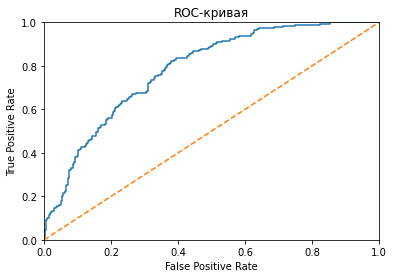

In [57]:
# Модель без учёта дисбаланса
model = LogisticRegression(random_state=12345, solver='liblinear') # считаем, во сколько раз класс «0» встречается чаще класса «1»
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
print("Соотношение нулей и единиц в таблице")
print(df['exited'].value_counts() / df.shape[0])
print()
print("------------------------------------------------------")
print("Модель без учёта дисбаланса")
print_result()


Балансировка тренировочной выборки
Counter({0: 6352, 1: 1648})
Counter({0: 6352, 1: 3176})
Counter({0: 3176, 1: 3176})
------------------------------------------------------
Модель c учётом дисбаланса
MAE: 0.28
F1: 0.48
AUC-ROC: 0.79

Матрица ошибок
Размер: 6352
Соотношение
0    3176
1    3176
Name: exited, dtype: int64
[[2269  907]
 [ 979 2197]]



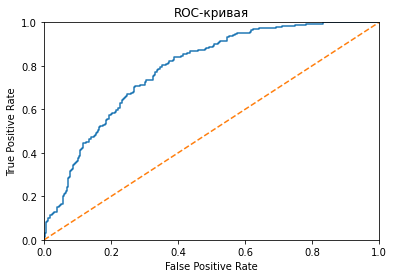

In [58]:
# Балансировка тренировочной выборки
print("Балансировка тренировочной выборки")
print(Counter(y_train))

over = RandomOverSampler(sampling_strategy=0.5)
X_train, y_train = over.fit_resample(X_train, y_train)
print(Counter(y_train))

under = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = under.fit_resample(X_train, y_train)
print(Counter(y_train))

model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)

print("------------------------------------------------------")
print("Модель c учётом дисбаланса")
print_result(m=model, X_t=X_train, y_t=y_train, X_v=X_valid, y_v=y_valid, plt_ROC=1)


*Соотношение действующих клиентов к ушедшим во всей таблице*:
- - действующих:    80%
- - ушедшие:    20%
*Модель без учёта дисбаланса:*
- - F1: 0.23
- - AUC-ROC: 0.78

*Модель c учётом дисбаланса:*
- - F1: 0.48
- - AUC-ROC: 0.79

### Результат: исследовали модель с учетом дисбаланса классов и без
- Сбалансировали количество ушедших клиентов к действующим.
- Обе модели лучше случайной модели т.к их значение AUC-ROC выше 0.5, но сбаланированная модель немного лучше.
- Среднее гармоническое полноты и точности (F1-мера) значительно вырасло после уравнения баланаса.

*Алгоритмы машинного обучения считают все объекты обучающей выборки равнозначными по умолчанию. 
Нам важно указать какие объекты важнее, их классу присваивается вес.
Для этого мы сбалансировали количество ушедших клиентов к действующим. После чего сравнили качество выборки с учетом дисбаланса и без.*

*Чтобы выявить, как сильно наша модель отличается от случайной, посчитали площадь под ROC-кривой. AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой») - метрика качества, которая изменяется от 0 до 1. AUC-ROC случайной модели равна 0.5.*

## Улучшение качества модели, учитывая дисбаланс классов. Обучение разных моделей и поиск лучшей.

In [23]:
def teach_and_print_best_model_score(model):
    model.fit(X_train, y_train)
    result = model.fit(X_train, y_train)
    print('Best Hyperparameters: %s' % result.best_params_)

    # Проверка на валидационной выборке
    y_pred = model.predict(X_valid)
    predictions = [round(value) for value in y_pred]
    print("MAE: %.2f" % mean_absolute_error(y_valid,predictions))
    print("F1: %.2f" % f1_score(y_valid, predictions))
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
    print("AUC-ROC: %.2f" % auc_roc)


In [24]:
%%time
param_grid = {
"max_depth": [3, 4, 7, 10, 25],
"gamma": [0.5, 1, 5, 10, 25],
"min_child_weight": [1, 3, 5, 10, 25],
"reg_lambda": [5, 10, 50, 100, 300],
"scale_pos_weight": [1, 3, 5, 10, 25]
}
# Grid Search CV implementation
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", verbosity = 0);
hgs_model = HalvingGridSearchCV(xgb_cl, param_grid, scoring="roc_auc", n_jobs=-1, min_resources="exhaust", factor=3)

teach_and_print_best_model_score(hgs_model)


Best Hyperparameters: {'gamma': 1, 'max_depth': 10, 'min_child_weight': 3, 'reg_lambda': 50, 'scale_pos_weight': 25}
MAE: 0.36
F1: 0.48
AUC-ROC: 0.84
Wall time: 6min 49s


In [25]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}
rs_model = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                   param_distributions = rf_grid, 
                   cv = 5, n_iter = 100)

teach_and_print_best_model_score(rs_model)


Best Hyperparameters: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
MAE: 0.18
F1: 0.59
AUC-ROC: 0.84
Wall time: 1h 36min 56s


### Результат: обучение разных моделей и поиск лучшей.

- Модель с наименьшим отклонением и высокой точностью: rs_model.
- Качество моделей выше случайной (AUC-ROC = 0.5).

*Метрика качества — MAE (mean absolute error) измеряет среднюю сумму разности между фактическим значением и прогнозируемым значением для всех точек данных.
Чем меньше MAE, тем точнее наше предсказание. Оптимум достигается в точке 0, то есть мы идеально предсказываем.
Она похожа на MSE, но в ней нет возведения в квадрат.
Константная модель выбирается так, чтобы значение метрики *MAE* было предельно низким.*

# Тестирование

DummyClassifier: 0.80
0    0.7963
1    0.2037
Name: exited, dtype: float64

Наилучшая модель
MAE на обучающей выборке: 0.00
MAE на тестовой выборке: 0.17
F1: 0.60
AUC-ROC: 0.85


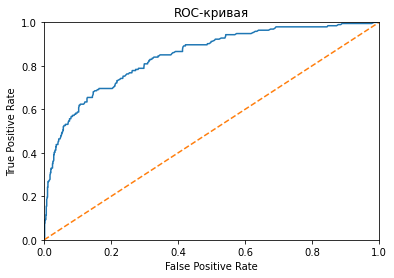

Wall time: 50min 4s


In [26]:
%%time

model = rs_model
model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

clf = DummyClassifier(strategy='most_frequent', random_state=12345)
clf.fit(X_train, y_train)
print("DummyClassifier: %.2f" % clf.score(X_test, y_test))
print(df['exited'].value_counts() / df.shape[0])
print()
print("Наилучшая модель")
print("MAE на обучающей выборке: %.2f" % mean_absolute_error(y_train, predictions_train))
print("MAE на тестовой выборке: %.2f" % mean_absolute_error(y_test, predictions_test))
print("F1: %.2f" % f1_score(y_test, predictions_test))
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
print("AUC-ROC: %.2f" % auc_roc)

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


# Заключение:
- Загрузили и подготовили данные.
- Исследовали баланс классов, обучили модель без учёта дисбаланса.
- Улучшили качество модели, учитывая дисбаланс классов. Обучили разные модели и нашли лучшую - rs_model.
- Провели финальное тестирование.